In [1]:
%config Completer.use_jedi = False

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import geoplot as gplt
import geopandas as gpd
import os
import copy
from copy import deepcopy
from shapely.geometry import Point, Polygon
from jmetal.util.constraint_handling import overall_constraint_violation_degree
from scipy.spatial.distance import squareform 
from scipy.spatial.distance import pdist
from jmetal.util.observer import ProgressBarObserver

from jmetal.util.constraint_handling import *
from Problem.JMetalPy_modified import *
from Problem.ConstraintEvaluation import *
from Problem.PerformanceObserver import *
from Problem.InitialSolution import *
from Problem.FitnessEvaluation import *
from Problem.PlotFunctions import *
from Problem.RoutingContext import *
from Problem.VehicleFunctions import *
from Problem.VRP import *
from Problem.utils import *
# https://stackoverflow.com/questions/40536560/ipython-and-jupyter-autocomplete-not-working#40544668
api = "Tfmt6Sxyn-nfinSHUyUo3xmVDWdtwAUyh6C8Y3HTZhU"

dataset = "UK25_8"
meta_data, distance_data, station_data = parse_UK_Data("../datasets/{}/{}.txt".format(dataset[:-2],dataset))

#station_coordinates = generate_coordinates(station_data, to_csv=True, filename=dataset)
location_context = "United Kingdom"
#station_coordinates = generate_coordinates(station_data,location_context,to_csv=True,filename=dataset)
station_coordinates = pd.read_csv('../datasets/{}/{}_coordinates.csv'.format(dataset[:-2],dataset), encoding='utf-8')
points_coordinate = station_coordinates[["lat", "lng"]].to_numpy()

# #UK = gpd.read_file("../datasets/united_kingdom_european_regions/Regions__December_2019__Boundaries_EN_BFC-shp/Regions__December_2019__Boundaries_EN_BFC.shp")
# dbf = gpd.GeoDataFrame.from_file(u"../datasets/united_kingdom_european_regions/european_region_region.dbf")
# dbf = dbf.to_crs("EPSG:4326")
meta_data["F-C Empty (l/100km)"] = 12.5
meta_data["F-C Full (l/100km)"] = 15
meta_data["Vehicle Weight"] = 3000
# #distance_matrix_here,time_matrix_here,_ = generate_large_distance_matrix(points_coordinate,api)

distance_matrix_here,time_matrix_here = load_saved_here_data("../datasets/{}/".format(dataset[:-2]),dataset)

distance_matrix_here = distance_matrix_here.to_numpy()
time_matrix_here = time_matrix_here.to_numpy()

routingContext = RoutingContext(distance_matrix=distance_matrix_here,time_matrix=time_matrix_here,station_coordinates=station_coordinates,station_data=station_data,meta_data=meta_data)
startNodes = {"UK20_1":[0,6,10,15],"UK25":[0,6,10,15],"UK50":[0,6,10,15,21,35,40],"UK75":[0,6,10,15,21,35,40,60,31,68]}
endNodes = {"UK20_1":[4,20,2,5],"UK25":[4,20,2,5,22],"UK50":[4,20,2,5,32,45,1],"UK75":[4,20,2,5,32,45,1]}



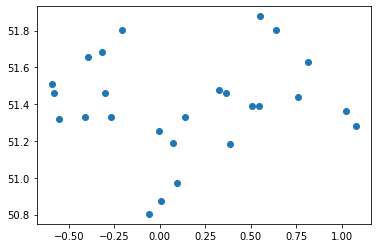

In [3]:
plt.scatter(points_coordinate[:,1],points_coordinate[:,0])

In [4]:
startNodeIndeces = startNodes[dataset[:-2]]
endNodeIndeces = endNodes[dataset[:-2]]
locationNodeIndeces = list((set(range(len(points_coordinate))) - set(startNodeIndeces)) - set(endNodeIndeces))

vehicleData = {"emptyWeights":[3000,5500],"maxLoads":[3650,8500],"fuelEmpty":[12,22.5],"fuelFull":[15,27.5]}


vehicles = initializeVehicles(startIndices=startNodeIndeces,vehicleData=vehicleData,
                                                            routingContext=routingContext,heterogeneousFleet=True)

customer_demands = station_data.T.loc["Demand(kg)"].astype(int).to_numpy()
customer_demands[startNodeIndeces+endNodeIndeces] = 0
station_data["Demand(kg)"] = customer_demands

translate_dict = {}
for i,x in enumerate(endNodeIndeces):
    translate_dict[x] = 100+i
initial_solution = cheapest_insertion_dict(locationNodeIndeces,vehicles,endNodeIndeces,routingContext)



cost_function_dict = {"distance_matrix":distance_matrix_here,"time_matrix":time_matrix_here,
                              "demands":customer_demands,"vehicle_weight":3000,"start_positions":startNodeIndeces,"meta_data":meta_data}


min_allowed_drivetime_hours = 0


data_model_input_multi_objective = {'routing_context':routingContext,'vehicles':vehicles,'end_points':endNodeIndeces,'pickup_points':locationNodeIndeces,
                                    'initial_solution':initial_solution,
                                    'objective_amount':2,'objective_labels':['Total Fuel','Total Drive Time'],
                                    'constraint_amount':6,'number_of_cities':routingContext.distance_matrix.shape[0],
                                    'min_drivetime':min_allowed_drivetime_hours}

data_model_input_single_objective = {'routing_context':routingContext,'vehicles':vehicles,'end_points':endNodeIndeces,'pickup_points':locationNodeIndeces,
                                    'initial_solution':initial_solution,
                                    'objective_amount':1,'objective_labels':['Total Fuel'],
                                    'constraint_amount':6,'number_of_cities':routingContext.distance_matrix.shape[0],
                                    'min_drivetime':min_allowed_drivetime_hours}

problem = VRP(data_model_input_multi_objective)

plot_data_storage_base = {'fitness':[], 'route_distance':[],'fuel_consumption':[],'vehicle_loads':[],'computation_times':[],'vehicle_route_time':[],'violation':[],'paths':[]}


amount_of_runs = 30
amount_of_evaluations = 3000
logpath = "parameter_data/{}/".format(dataset)
mutation_arange = np.arange(0.1,1,0.2)
crossover_arange = np.arange(0.25,0.8,0.25)
population_size_arange = np.arange(10,40,10)


genetic_algorithms_parameters = []

for x in mutation_arange:
    for y in crossover_arange:
        for z in population_size_arange:
            genetic_algorithms_parameters.append({"mutation":np.round(x,2),"crossover":np.round(y,2),"population_size":np.round(z,2)})


In [5]:
logpath

'parameter_data/UK25_8/'

# Paremeter Test 

# Simulated Annealing

In [6]:
from jmetal.algorithm.singleobjective import SimulatedAnnealing
from jmetal.operator.mutation import PermutationSwapMutation,ScrambleMutation,SimpleRandomMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.comparator import DominanceComparator
from datetime import datetime
parameter_list_SA = []
for x in mutation_arange:
    parameter_list_SA.append({"mutation":np.round(x,2)})



parameter_data_SA = []
computation_times_SA = []
results_SA = []
sa_log_data_DF = pd.DataFrame(columns=list(plot_data_storage_base.keys()))
for index,param in enumerate(parameter_list_SA):
    plot_data_SA = deepcopy(plot_data_storage_base)
    for x in range(amount_of_runs):
        problem_SA = VRP(data_model_input_single_objective)
        problem_SA.name = "SA"
        problem_SA.assignClosestEndPoint = True
        max_evaluations = amount_of_evaluations

        algorithm_SA = SimulatedAnnealing(problem=problem_SA,
                                       mutation=PermutationSwapMutation(param["mutation"]),
                                       termination_criterion=StoppingByEvaluations(max_evaluations))
       
        performance_observer_SA = PerformanceObserver(max_iter=max_evaluations,frequency=10,params=parameter_list_SA)
        performance_observer_SA.maxEpochs= len(parameter_list_SA) * amount_of_runs
        performance_observer_SA.currentEpoch = (index*amount_of_runs) + x

        algorithm_SA.observable.register(observer=performance_observer_SA)
        algorithm_SA.run() 
        
        solutions_SA = algorithm_SA.get_result()        
        store_plot_data(plot_data_SA,performance_observer_SA,solutions_SA)
        
    new_Row = pd.DataFrame.from_dict(plot_data_SA,orient="columns")
    new_Row.insert(0,"Parameters",[list(param.items())]*amount_of_runs)#["Parameters"] = param
    new_Row.insert(0,"Parameter Group",[index]*amount_of_runs)
    
    
    
    sa_log_data_DF = pd.concat([sa_log_data_DF,new_Row])
    
    parameter_data_SA.append({"parameters":param,"results":plot_data_SA})

sa_numerical_path = get_numerical_path(solutions_SA.path,vehicles)


Epoch:150 of 150
Evaluations: 3000/3000
Params: {'mutation': 0.9}
IGD:847.8887958038769
Best fitness: 341.0407                          
Best total fuel consumption:102.94 
Best total drive time:841.62                          
Computing time: 4.74s
Average computing speed: 633.18it/s                          
Current Route:[['V0', 16, 11, 9, 12, 25, 21, 20], ['V1', 14, 8, 19, 5], ['V3', 24, 22], ['V2', 1, 3, 13, 2], ['V4', 23, 7, 17, 18, 4]]
Flags: []
Violation:0
Vehicle Amount:5


In [7]:
sa_log_data_DF.to_csv("{}/SA.csv".format(logpath))

# Genetic Algorithm

In [8]:
from jmetal.algorithm.singleobjective import GeneticAlgorithm
from jmetal.operator.crossover import PMXCrossover
from jmetal.operator.selection import Selection
from jmetal.operator import SBXCrossover, RandomSolutionSelection,BestSolutionSelection
from jmetal.operator.mutation import PermutationSwapMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.observer import ProgressBarObserver, VisualizerObserver,PrintObjectivesObserver,BasicObserver
from jmetal.util.evaluator import MultiprocessEvaluator
from datetime import datetime


parameter_list_GA = genetic_algorithms_parameters

GA_log_data_DF = pd.DataFrame(columns=list(plot_data_storage_base.keys()))

for index,param in enumerate(parameter_list_GA):
    plot_data_GA = deepcopy(plot_data_storage_base)
    for x in range(amount_of_runs):
        problem_GA = VRP(data_model_input_single_objective)
        problem_GA.name = "GA"
        problem_GA.assignClosestEndPoint = True
        max_evaluations = amount_of_evaluations

        algorithm_GA = GeneticAlgorithm(problem=problem_GA,
                        population_size=param["population_size"],
                        offspring_population_size=param["population_size"],
                        mutation=PermutationSwapMutation(param["mutation"]),
                        crossover=PMXCrossover(param["crossover"]),
                        selection=BestSolutionSelection(),
                        termination_criterion=StoppingByEvaluations(max_evaluations=max_evaluations)
                        ,population_evaluator=MultiprocessEvaluator()
                        )


        performance_observer_GA = PerformanceObserver(max_iter=max_evaluations,frequency=1,params=parameter_list_GA)
        performance_observer_GA.maxEpochs= len(parameter_list_GA) * amount_of_runs
        performance_observer_GA.currentEpoch = (index*amount_of_runs) + x
        algorithm_GA.observable.register(observer=performance_observer_GA)
        start_time = datetime.now() 
        algorithm_GA.run()
        run_time = datetime.now() - start_time
        solutions_GA = algorithm_GA.get_result()
        

        store_plot_data(plot_data_GA,performance_observer_GA,solutions_GA)
        
    new_Row = pd.DataFrame.from_dict(plot_data_GA,orient="columns")
    new_Row.insert(0,"Parameters",[list(param.items())]*amount_of_runs)
    new_Row.insert(0,"Parameter Group",[index]*amount_of_runs)
    
    
    
    GA_log_data_DF = pd.concat([GA_log_data_DF,new_Row])
    

#saveParameterData(logPath,"GA_data_10_pop",parameter_data_GA)

Epoch:1350 of 1350
Evaluations: 3000/3000
Params: {'mutation': 0.9, 'crossover': 0.75, 'population_size': 30}
IGD:847.8887958038769
Best fitness: 341.0407                          
Best total fuel consumption:102.94 
Best total drive time:841.62                          
Computing time: 4.49s
Average computing speed: 667.58it/s                          
Current Route:[['V0', 16, 11, 9, 12, 25, 21, 20], ['V1', 14, 8, 19, 5], ['V3', 24, 22], ['V2', 1, 3, 13, 2], ['V4', 23, 7, 17, 18, 4]]
Flags: []
Violation:0
Vehicle Amount:5


Process ForkPoolWorker-5398:
Process ForkPoolWorker-5399:
Process ForkPoolWorker-5400:
Traceback (most recent call last):
Process ForkPoolWorker-5397:
Traceback (most recent call last):
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.9/multiproc

In [9]:
GA_log_data_DF.to_csv("{}/GA.csv".format(logpath))

# NSGA-II

In [10]:
from jmetal.algorithm.multiobjective.nsgaiii import NSGAII, UniformReferenceDirectionFactory
from jmetal.operator.crossover import PMXCrossover,CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation, ScrambleMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.operator import SBXCrossover, RandomSolutionSelection,BestSolutionSelection,RankingAndCrowdingDistanceSelection
from jmetal.operator.selection import   RouletteWheelSelection
from jmetal.util.solution import get_non_dominated_solutions
from datetime import datetime

parameter_list_NSGAII = genetic_algorithms_parameters# [{"mutation":0.8,"crossover":0.5,"population_size":20}]#,{"mutation":0.8,"crossover":0.5}]
# for x in mutation_arange:
#     for y in crossover_arange:
#         parameter_list_NSGAII.append({"mutation":round(x,2),"crossover":round(y,2)})


NSGA2_log_data_DF = pd.DataFrame(columns=list(plot_data_storage_base.keys()))
for index,param in enumerate(parameter_list_NSGAII):
    plot_data_NSGAII = deepcopy(plot_data_storage_base)
    for x in range(amount_of_runs):
        problem_NSGAII = VRP(data_model_input_multi_objective)
        problem_NSGAII.name = "NSGA-II"
        problem_NSGAII.assignClosestEndPoint = True
        max_evaluations = amount_of_evaluations

        algorithm_NSGAII = NSGAII(problem=problem_NSGAII,
                                population_size=param["population_size"],
                                offspring_population_size=param["population_size"],
                                mutation=PermutationSwapMutation(param["mutation"]),
                                crossover=PMXCrossover(param["crossover"]),
                                termination_criterion=StoppingByEvaluations(max_evaluations),
                                population_evaluator=MultiprocessEvaluator()

                                   )

        performance_observer_NSGAII = PerformanceObserver(max_iter=max_evaluations,frequency=1,params=parameter_list_NSGAII)
        performance_observer_NSGAII.maxEpochs= len(parameter_list_NSGAII) * amount_of_runs
        performance_observer_NSGAII.currentEpoch = (index*amount_of_runs) + x
        algorithm_NSGAII.observable.register(observer=performance_observer_NSGAII)
        algorithm_NSGAII.run()
        
        solutions_NSGAII = algorithm_NSGAII.get_result()
        front_NSGAII = get_non_dominated_solutions(solutions_NSGAII)
        
        store_plot_data(plot_data_NSGAII,performance_observer_NSGAII,front_NSGAII[0])
        
    new_Row = pd.DataFrame.from_dict(plot_data_NSGAII,orient="columns")
    new_Row.insert(0,"Parameters",[list(param.items())]*amount_of_runs)
    new_Row.insert(0,"Parameter Group",[index]*amount_of_runs)
    
    NSGA2_log_data_DF = pd.concat([NSGA2_log_data_DF,new_Row])



Epoch:1350 of 1350
Evaluations: 3000/3000
Params: {'mutation': 0.9, 'crossover': 0.75, 'population_size': 30} 
IGD:259.5715753420122
Best fitness: 103.237 --- 257.4667                        
Best total fuel consumption:103.24 
Computing time: 4.79s                        
Average computing speed: 626.26it/s
Current Route:[['V0', 11, 9, 12, 25, 21, 20], ['V1', 8, 14, 16, 19, 5], ['V2', 24, 1, 3, 13, 2], ['V4', 23, 7, 17, 18, 4]]
Flags: []                        
Violation:0
Vehicle amount:4


Process ForkPoolWorker-10797:
Process ForkPoolWorker-10800:
Process ForkPoolWorker-10798:
Process ForkPoolWorker-10799:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.9/multi

In [11]:
NSGA2_log_data_DF.to_csv("{}/NSGA2.csv".format(logpath))

# NSGA-III

In [12]:
from jmetal.algorithm.multiobjective.nsgaiii import NSGAIII, UniformReferenceDirectionFactory,ReferenceDirectionFactory
from jmetal.operator.crossover import PMXCrossover, CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation,ScrambleMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.util.solution import get_non_dominated_solutions
from jmetal.util.observer import ProgressBarObserver
from jmetal.util.density_estimator import CrowdingDistance
from jmetal.util.ranking import FastNonDominatedRanking
from jmetal.util.comparator import DominanceComparator, Comparator, MultiComparator

parameter_list_NSGAIII = genetic_algorithms_parameters#[{"mutation":0.6,"crossover":0.2,"population_size":20}]#{"mutation":0.6,"crossover":0.5},{"mutation":0.6,"crossover":0.8}]

NSGA3_log_data_DF = pd.DataFrame(columns=list(plot_data_storage_base.keys()))
for index,param in enumerate(parameter_list_NSGAIII):
    plot_data_NSGAIII = deepcopy(plot_data_storage_base)
    for x in range(amount_of_runs):
        
        problem_NSGAIII = VRP(data_model_input_multi_objective)
        problem_NSGAIII.name = "NSGA-III"
        problem_NSGAIII.assignClosestEndPoint = True
        max_evaluations = amount_of_evaluations
        
        algorithm_NSGAIII = NSGAIII(problem=problem_NSGAIII,
                                population_size=param["population_size"],
                                reference_directions=UniformReferenceDirectionFactory(2, n_points=8),
                                mutation= PermutationSwapMutation(param["mutation"]),
                                crossover=PMXCrossover(param["crossover"]),
                                termination_criterion=StoppingByEvaluations(max_evaluations)
                                ,population_evaluator=MultiprocessEvaluator()
                                   )
        performance_observer_NSGAIII = PerformanceObserver(max_iter=max_evaluations,frequency=1,params=parameter_list_NSGAIII)
        performance_observer_NSGAIII.maxEpochs= len(parameter_list_NSGAIII) * amount_of_runs
        performance_observer_NSGAIII.currentEpoch = (index*amount_of_runs) + x

        algorithm_NSGAIII.observable.register(observer=performance_observer_NSGAIII)
        algorithm_NSGAIII.run()
        
        solutions_NSGAIII = algorithm_NSGAIII.get_result()
        front_NSGAIII = get_non_dominated_solutions(solutions_NSGAIII)
        
        store_plot_data(plot_data_NSGAIII,performance_observer_NSGAIII,front_NSGAIII[0])
        
        
    new_Row = pd.DataFrame.from_dict(plot_data_NSGAIII,orient="columns")
    new_Row.insert(0,"Parameters",[list(param.items())]*amount_of_runs)
    new_Row.insert(0,"Parameter Group",[index]*amount_of_runs)
    
    NSGA3_log_data_DF = pd.concat([NSGA3_log_data_DF,new_Row])
        
nsga3_numerical_path = get_numerical_path(front_NSGAIII[0].path,vehicles)


Epoch:1350 of 1350
Evaluations: 3000/3000
Params: {'mutation': 0.9, 'crossover': 0.75, 'population_size': 30} 
IGD:247.99676025888013
Best fitness: 104.2735 --- 238.1                        
Best total fuel consumption:104.27 
Computing time: 5.01s                        
Average computing speed: 598.69it/s
Current Route:[['V0', 11, 9, 12, 25, 21, 20], ['V1', 16, 14, 8, 19, 5], ['V3', 24, 22], ['V2', 1, 3, 13, 2], ['V4', 23, 7, 17, 18, 4]]
Flags: []                        
Violation:0
Vehicle amount:5


Process ForkPoolWorker-16197:
Process ForkPoolWorker-16199:
Process ForkPoolWorker-16198:
Process ForkPoolWorker-16200:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  F

In [13]:
NSGA3_log_data_DF.to_csv("{}/NSGA3.csv".format(logpath))

# UNSGA-III

In [14]:
from jmetal.algorithm.multiobjective.nsgaiii import NSGAIII, UniformReferenceDirectionFactory,ReferenceDirectionFactory
from jmetal.operator.crossover import PMXCrossover, CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation,ScrambleMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.util.solution import get_non_dominated_solutions
from jmetal.util.observer import ProgressBarObserver
from jmetal.util.density_estimator import CrowdingDistance
from jmetal.util.ranking import FastNonDominatedRanking
from jmetal.util.comparator import DominanceComparator, Comparator, MultiComparator

parameter_list_UNSGAIII = genetic_algorithms_parameters
UNSGA3_log_data_DF = pd.DataFrame(columns=list(plot_data_storage_base.keys()))
for index,param in enumerate(parameter_list_UNSGAIII):
    plot_data_UNSGAIII = deepcopy(plot_data_storage_base)
    for x in range(amount_of_runs):
        
        problem_UNSGAIII = VRP(data_model_input_multi_objective)
        problem_UNSGAIII.name = "NSGA-III"
        problem_UNSGAIII.assignClosestEndPoint = True
        max_evaluations = amount_of_evaluations
        
        algorithm_UNSGAIII = UNSGAIII(problem=problem_UNSGAIII,
                                population_size=param["population_size"],
                                reference_directions=UniformReferenceDirectionFactory(2, n_points=8),
                                mutation= PermutationSwapMutation(param["mutation"]),
                                crossover=PMXCrossover(param["crossover"]),
                                termination_criterion=StoppingByEvaluations(max_evaluations)
                                ,population_evaluator=MultiprocessEvaluator()
                                   )
        performance_observer_UNSGAIII = PerformanceObserver(max_iter=max_evaluations,frequency=1,params=parameter_list_UNSGAIII)
        performance_observer_UNSGAIII.maxEpochs= len(parameter_list_UNSGAIII) * amount_of_runs
        performance_observer_UNSGAIII.currentEpoch = (index*amount_of_runs) + x

        algorithm_UNSGAIII.observable.register(observer=performance_observer_UNSGAIII)
        algorithm_UNSGAIII.run()
        
        solutions_UNSGAIII = algorithm_UNSGAIII.get_result()
        front_UNSGAIII = get_non_dominated_solutions(solutions_UNSGAIII)
        
        store_plot_data(plot_data_UNSGAIII,performance_observer_UNSGAIII,front_UNSGAIII[0])
        
        
    new_Row = pd.DataFrame.from_dict(plot_data_UNSGAIII,orient="columns")
    new_Row.insert(0,"Parameters",[list(param.items())]*amount_of_runs)
    new_Row.insert(0,"Parameter Group",[index]*amount_of_runs)
    
    UNSGA3_log_data_DF = pd.concat([UNSGA3_log_data_DF,new_Row])
        
Unsga3_numerical_path = get_numerical_path(front_UNSGAIII[0].path,vehicles)

Epoch:1350 of 1350
Evaluations: 3000/3000
Params: {'mutation': 0.9, 'crossover': 0.75, 'population_size': 30} 
IGD:261.7543972984465
Best fitness: 132.878 --- 236.5167                        
Best total fuel consumption:132.88 
Computing time: 5.42s                        
Average computing speed: 553.69it/s
Current Route:[['V0', 11, 9, 12, 19, 25, 21, 20], ['V1', 8, 14, 16, 5], ['V3', 3, 1, 22], ['V2', 24, 13, 2], ['V4', 23, 7, 17, 18, 4]]
Flags: []                        
Violation:0
Vehicle amount:5


Process ForkPoolWorker-21597:
Process ForkPoolWorker-21600:
Process ForkPoolWorker-21599:
Process ForkPoolWorker-21598:
Traceback (most recent call last):
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  F

In [15]:
UNSGA3_log_data_DF.to_csv("{}/UNSGA3.csv".format(logpath))

# IBEA

In [18]:
from jmetal.algorithm.multiobjective.ibea import IBEA
from jmetal.operator.crossover import PMXCrossover,CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation, ScrambleMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.operator import SBXCrossover, RandomSolutionSelection,BestSolutionSelection,RankingAndCrowdingDistanceSelection
from jmetal.operator.selection import   RouletteWheelSelection
from jmetal.util.solution import get_non_dominated_solutions
from datetime import datetime

parameter_list_IBEA =genetic_algorithms_parameters

IBEA_log_data_DF = pd.DataFrame(columns=list(plot_data_storage_base.keys()))
for index,param in enumerate(parameter_list_IBEA):
    plot_data_IBEA = deepcopy(plot_data_storage_base)
    for x in range(amount_of_runs):
        problem_IBEA = VRP(data_model_input_multi_objective)
        problem_IBEA.name = "IBEA"
        problem_IBEA.assignClosestEndPoint = True
        max_evaluations = amount_of_evaluations

        algorithm_IBEA = IBEA(problem=problem_IBEA,
                                population_size=param["population_size"],
                                offspring_population_size=param["population_size"],
                                kappa =1,
                                mutation=PermutationSwapMutation(param["mutation"]),
                                crossover=PMXCrossover(param["crossover"]),
                                termination_criterion=StoppingByEvaluations(max_evaluations),
                                population_evaluator=MultiprocessEvaluator(),
                                   )
        
        performance_observer_IBEA = PerformanceObserver(max_iter=max_evaluations,frequency=10,params=parameter_list_IBEA)
        performance_observer_IBEA.maxEpochs= len(parameter_list_IBEA) * amount_of_runs
        performance_observer_IBEA.currentEpoch = (index*amount_of_runs) + x
         
        
        algorithm_IBEA.observable.register(observer=performance_observer_IBEA)
        algorithm_IBEA.run()
        
        solutions_IBEA = algorithm_IBEA.get_result()
        front_IBEA = get_non_dominated_solutions(solutions_IBEA)
        store_plot_data(plot_data_IBEA,performance_observer_IBEA,front_IBEA[0])
    
    new_Row = pd.DataFrame.from_dict(plot_data_IBEA,orient="columns")
    new_Row.insert(0,"Parameters",[list(param.items())]*amount_of_runs)
    new_Row.insert(0,"Parameter Group",[index]*amount_of_runs)
    
    IBEA_log_data_DF = pd.concat([IBEA_log_data_DF,new_Row])
    
    
ibea_numerical_path = get_numerical_path(front_IBEA[0].path,vehicles)

Epoch:1 of 1350
Evaluations: 910/3000
Params: {'mutation': 0.1, 'crossover': 0.25, 'population_size': 10} 
IGD:262.5067095284005
Best fitness: 110.5358 --- 238.1                        
Best total fuel consumption:110.54 
Computing time: 2.86s                        
Average computing speed: 318.3it/s
Current Route:[['V0', 9, 11, 12, 19, 25, 21, 20], ['V1', 16, 14, 8, 2], ['V2', 24, 22], ['V3', 1, 3, 13, 2], ['V4', 23, 7, 17, 18, 4]]
Flags: []                        
Violation:0
Vehicle amount:5


Process ForkPoolWorker-27002:
Process ForkPoolWorker-27003:
Process ForkPoolWorker-27004:
Process ForkPoolWorker-27001:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  F

KeyboardInterrupt: 

In [17]:
IBEA_log_data_DF.to_csv("{}/IBEA.csv".format(logpath))